# The Annotated Construct and Reducer Functions

In [39]:
from langgraph.graph import START, END, StateGraph, add_messages, MessagesState
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, RemoveMessage
from collections.abc import Sequence
from typing import Literal, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
import config

In [3]:
my_list = add_messages([HumanMessage("Hi! I'm Oscar."), 
                        AIMessage("Hey, Oscar. How can I assist you?")],
                       [HumanMessage("Could you summarize today's news?")])

```python
add_messages(existing_messages, new_items)
```

* **`existing_messages`** → your current list of messages (conversation history).
* **`new_items`** → can be:

  1. A list of new messages (e.g., `AIMessage`, `HumanMessage`) → they get **added**.
  2. A list of `RemoveMessage(id=...)` objects → those messages get **removed**.
  3. A mix of both (add some, remove some).

---

In [4]:
my_list

[HumanMessage(content="Hi! I'm Oscar.", additional_kwargs={}, response_metadata={}, id='0d3bea0b-8cf6-4a6a-9cd8-7a81ee821c48'),
 AIMessage(content='Hey, Oscar. How can I assist you?', additional_kwargs={}, response_metadata={}, id='b9285fba-185f-4342-8cb1-1911a75abec3'),
 HumanMessage(content="Could you summarize today's news?", additional_kwargs={}, response_metadata={}, id='c790bddb-e900-4294-820b-9d0fb3ecfa3b')]

In [11]:
# Define the State (Annotated)
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

1. **`class State(TypedDict):`**

   * This defines a **dictionary-like structure** (a `TypedDict` is just a special dictionary where you can specify what keys and value types are allowed).
   * So, `State` is like a "template" for a dictionary.

2. **`messages: ...`**

   * This means the dictionary must have a key called `"messages"`.

3. **`Sequence[BaseMessage]`**

   * The value of `"messages"` should be a list (or something like a list) containing objects of type `BaseMessage`.

4. **`Annotated[..., add_messages]`**

   * `Annotated` adds extra info (metadata).
   * Here, it says `"messages"` isn’t just any list of `BaseMessage`, but it has some special behavior defined by `add_messages`.
   * Think of it like a **tag or note** attached to that field.

---

In [9]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=config.gemini_api_key,
    temperature=0,
    max_tokens=250,
    model_kwargs={"seed": 42}
)

In [10]:
def AskGeminiAI(question):
    response = llm.invoke(question)
    return response

In [12]:
# Ask Question Node
def ask_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "What is your question?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [24]:
# Chatbot Node
def chatbot(state: State) -> State:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
    
    response = AskGeminiAI(state["messages"])
    response.pretty_print()
    
    return State(messages = [response])

In [14]:
# Ask Another Question Node
def ask_another_question(state: State) -> State:
    
    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return State(messages = [AIMessage(question), HumanMessage(input())])

In [15]:
def routing_function(state: State) -> Literal["ask_question", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

# Defining a Graph

In [26]:
graph = StateGraph(State)

In [27]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)

In [28]:
graph_compiled = graph.compile()

In [29]:
print(graph_compiled.get_graph().draw_ascii())

          +-----------+       
          | __start__ |       
          +-----------+       
                 *            
                 *            
                 *            
         +--------------+     
         | ask_question |     
         +--------------+     
          ***         ..      
         *              ..    
       **                 ..  
+---------+                 . 
| chatbot |               ..  
+---------+             ..    
          ***         ..      
             *      ..        
              **   .          
     +----------------------+ 
     | ask_another_question | 
     +----------------------+ 
                 .            
                 .            
                 .            
            +---------+       
            | __end__ |       
            +---------+       


In [30]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?


 Who is luffy?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Who is luffy?
================================== Ai Message ==================================

Monkey D. Luffy, often referred to as just Luffy, is the main protagonist of the popular manga and anime series *One Piece*. He's a young pirate with the dream of becoming the King of the Pirates.

Here's a breakdown of who he is:

*   **Appearance:** Luffy is known for his signature straw hat (given to him by the legendary pirate Shanks), his black hair, and a scar under his left eye.

*   **Personality:** He's cheerful, optimistic, and incredibly loyal to his friends. He's also known for his insatiable appetite and his simple-minded, yet surprisingly insightful, nature.

*   **Abilities:** Luffy ate the Gum-Gum Fruit (Gomu Gomu no Mi), a Paramecia-type Devil Fruit, which turned 

 yes



-------> ENTERING ask_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Who is luffy?
================================== Ai Message ==================================

Monkey D. Luffy, often referred to as just Luffy, is the main protagonist of the popular manga and anime series *One Piece*. He's a young pirate with the dream of becoming the King of the Pirates.

Here's a breakdown of who he is:

*   **Appearance:** Luffy is known for his signature straw hat (given to him by the legendary pirate Shanks), his black hair, and a scar under his left eye.

*   **Personality:** He's cheerful, optimistic, and incredibly loyal to his friends. He's also known for his insatiable appetite and his simple-minded, yet surprisingly insightful, nature.

*   **Abilities:** Luffy ate the Gum-Gum Fruit (Gomu Gomu no Mi), a Paramecia-type Devil Fruit, which tu

 who is his father?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Who is luffy?
================================== Ai Message ==================================

Monkey D. Luffy, often referred to as just Luffy, is the main protagonist of the popular manga and anime series *One Piece*. He's a young pirate with the dream of becoming the King of the Pirates.

Here's a breakdown of who he is:

*   **Appearance:** Luffy is known for his signature straw hat (given to him by the legendary pirate Shanks), his black hair, and a scar under his left eye.

*   **Personality:** He's cheerful, optimistic, and incredibly loyal to his friends. He's also known for his insatiable appetite and his simple-minded, yet surprisingly insightful, nature.

*   **Abilities:** Luffy ate the Gum-Gum Fruit (Gomu Gomu no Mi), a Paramecia-type Devil Fruit, which turned 

 No


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='04ba7df3-0905-493c-9a63-2247e6bbd541'),
  HumanMessage(content='Who is luffy?', additional_kwargs={}, response_metadata={}, id='6eecdb97-a114-4c59-8e3d-d19de0b36909'),
  AIMessage(content="Monkey D. Luffy, often referred to as just Luffy, is the main protagonist of the popular manga and anime series *One Piece*. He's a young pirate with the dream of becoming the King of the Pirates.\n\nHere's a breakdown of who he is:\n\n*   **Appearance:** Luffy is known for his signature straw hat (given to him by the legendary pirate Shanks), his black hair, and a scar under his left eye.\n\n*   **Personality:** He's cheerful, optimistic, and incredibly loyal to his friends. He's also known for his insatiable appetite and his simple-minded, yet surprisingly insightful, nature.\n\n*   **Abilities:** Luffy ate the Gum-Gum Fruit (Gomu Gomu no Mi), a Paramecia-type Devil Fruit, which turned his body

# The MessagesState class

Without using State class but using inbuilt MessagesState

In [32]:
def ask_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "What is your question?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [33]:
def chatbot(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
    
    response = AskGeminiAI(state["messages"])
    response.pretty_print()
    
    return MessagesState(messages = [response])

In [34]:
def ask_another_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [35]:
graph = StateGraph(MessagesState)

In [36]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)

In [37]:
graph_compiled = graph.compile()

In [38]:
graph_compiled.invoke(MessagesState(messages = []))


-------> ENTERING ask_question:
What is your question?


 Which is the first pokemon Ash caught?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Which is the first pokemon Ash caught?
================================== Ai Message ==================================

The first Pokémon Ash caught was **Caterpie**.

-------> ENTERING ask_another_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Which is the first pokemon Ash caught?
================================== Ai Message ==================================

The first Pokémon Ash caught was **Caterpie**.
Would you like to ask one more question (yes/no)?


 yes



-------> ENTERING ask_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Which is the first pokemon Ash caught?
================================== Ai Message ==================================

The first Pokémon Ash caught was **Caterpie**.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
What is your question?


 What type is that?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

Which is the first pokemon Ash caught?
================================== Ai Message ==================================

The first Pokémon Ash caught was **Caterpie**.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

What type is that?
================================== Ai Message ==================================

Caterpie is a **Bug** type Pokémon.

-------> ENTERING ask_another_question:
==================================

 No


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='37e2b8f7-5f80-4d97-868b-9e0201789c07'),
  HumanMessage(content='Which is the first pokemon Ash caught?', additional_kwargs={}, response_metadata={}, id='5948e17c-a992-485c-b209-1bb864777d75'),
  AIMessage(content='The first Pokémon Ash caught was **Caterpie**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--9536c6c3-ee37-4b39-aa73-b4ca2acd445c-0', usage_metadata={'input_tokens': 13, 'output_tokens': 11, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}}),
  AIMessage(content='Would you like to ask one more question (yes/no)?', additional_kwargs={}, response_metadata={}, id='de5e5842-baef-418f-acd4-00a0b096dcee'),
  HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='083e4a97-758a-4278-92a6-cea588ac16d2

# The RemoveMessages class

In [45]:
my_list = add_messages([AIMessage("What is your question?"), 
                        HumanMessage("Could you tell me a grook by Piet Hein?"),
                        AIMessage("Certainly! Here's a well-known grook by Piet Hein..."),
                        AIMessage("Would you like to ask one more question?"),
                        HumanMessage("yes"),
                        AIMessage("What is your question?"),
                        HumanMessage("Where was the poet born?"),
                        AIMessage("Piet Hein was born in Copenhagen, Denmark, on December 16, 1905."),
                        AIMessage("Would you like to ask one more question?")],
                       [HumanMessage("yes")]
                      )

In [61]:
# All the elements except last 5
my_list[:-5]

[AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='b05b6c82-688b-4e00-abed-d4c9d03755bc'),
 HumanMessage(content='Could you tell me a grook by Piet Hein?', additional_kwargs={}, response_metadata={}, id='49f79089-476d-4384-9395-fdc711645205'),
 AIMessage(content="Certainly! Here's a well-known grook by Piet Hein...", additional_kwargs={}, response_metadata={}, id='0277e540-16e9-4f46-bd68-18f951b7fe92'),
 AIMessage(content='Would you like to ask one more question?', additional_kwargs={}, response_metadata={}, id='1deb2bca-ca88-41b7-bd9d-bcd2c989602e'),
 HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='0da6efbd-d7e3-4fa0-903d-3f3c6619bd16')]

In [57]:
remove_messages = [RemoveMessage(id = i.id) for i in my_list[:-5]]

1. `my_list[:-5]` → takes **all elements except the last 5**.
2. For each `i` in that slice:

   * It creates a `RemoveMessage` object.
   * The argument `id=i.id` passes the **`id` attribute** of the message object `i`.

So you end up with a list of `RemoveMessage` objects, each storing the same `id` as the original message.

---

In [60]:
# Messages to be removed:
remove_messages

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='b05b6c82-688b-4e00-abed-d4c9d03755bc'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='49f79089-476d-4384-9395-fdc711645205'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='0277e540-16e9-4f46-bd68-18f951b7fe92'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1deb2bca-ca88-41b7-bd9d-bcd2c989602e'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='0da6efbd-d7e3-4fa0-903d-3f3c6619bd16')]

In [59]:
add_messages(my_list, remove_messages)

[AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='dbae23e3-859d-43a5-b1db-7c9a8419bea9'),
 HumanMessage(content='Where was the poet born?', additional_kwargs={}, response_metadata={}, id='c2b05060-a542-4bed-a38c-1e5fa7b11d2d'),
 AIMessage(content='Piet Hein was born in Copenhagen, Denmark, on December 16, 1905.', additional_kwargs={}, response_metadata={}, id='14847b18-42a4-4542-b38d-7742769d826e'),
 AIMessage(content='Would you like to ask one more question?', additional_kwargs={}, response_metadata={}, id='eeab8083-ebf4-42fa-af46-53843dd612ec'),
 HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='c65c797c-3670-4716-93e9-15b39cb1ad97')]

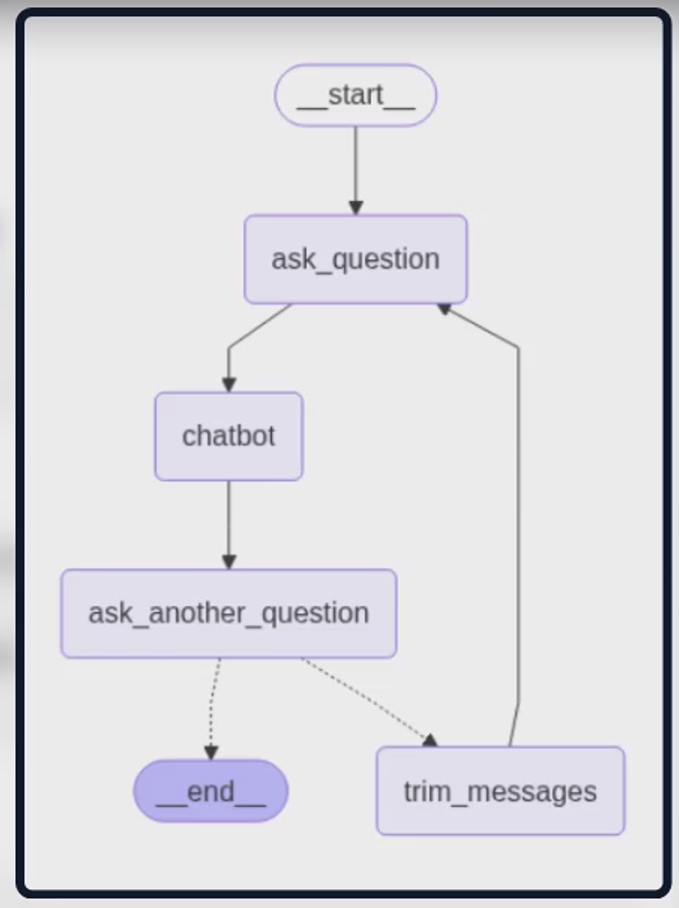

In [62]:
from IPython.display import Image, display

display(Image(filename = r"D:\AI-ML\LangGraph\Files\FlowDiagram2.png", width=300))

Adding new node "trim_messages"

In [64]:
def ask_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "What is your question?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [68]:
def chatbot(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()
    
    response = AskGeminiAI(state["messages"])
    response.pretty_print()
    
    return MessagesState(messages = [response])

In [66]:
def ask_another_question(state: MessagesState) -> MessagesState:
    
    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()
    
    question = "Would you like to ask one more question (yes/no)?"
    print(question)
    
    return MessagesState(messages = [AIMessage(question), HumanMessage(input())])

In [63]:
def trim_messages(state: MessagesState) -> MessagesState:
    print(f"\n-------> ENTERING trim_messages:")
    
    remove_messages = [RemoveMessage(id = i.id) for i in state["messages"][:-5]]
    
    return MessagesState(messages = remove_messages)

In [67]:
def routing_function(state: MessagesState) -> Literal["trim_messages", "__end__"]:
    
    if state["messages"][-1].content == "yes":
        return "trim_messages"
    else:
        return "__end__"

In [71]:
graph = StateGraph(MessagesState)

graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)
graph.add_node("trim_messages", trim_messages)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_edge("trim_messages", "ask_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)

graph_compiled = graph.compile()

print(graph_compiled.get_graph().draw_ascii())

                     +-----------+                   
                     | __start__ |                   
                     +-----------+                   
                            *                        
                            *                        
                            *                        
                    +--------------+                 
                    | ask_question |                 
                    +--------------+                 
                   ***            ***                
                 **                  ***             
               **                       **           
      +---------+                         **         
      | chatbot |                          *         
      +---------+                          *         
            *                              *         
            *                              *         
            *                              *         
+----------------------+    

In [72]:
graph_compiled.invoke(MessagesState(messages = []))


-------> ENTERING ask_question:
What is your question?


 My name is Suraj.



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

My name is Suraj.
================================== Ai Message ==================================

Okay, Suraj. It's nice to meet you. How can I help you today?

-------> ENTERING ask_another_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

My name is Suraj.
================================== Ai Message ==================================

Okay, Suraj. It's nice to meet you. How can I help you today?
Would you like to ask one more question (yes/no)?


 yes



-------> ENTERING trim_messages:

-------> ENTERING ask_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

My name is Suraj.
================================== Ai Message ==================================

Okay, Suraj. It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
What is your question?


 What is my name?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

My name is Suraj.
================================== Ai Message ==================================

Okay, Suraj. It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Suraj.

-------> ENTERING ask_another_question:
================================== Ai Message ============

 yes



-------> ENTERING trim_messages:

-------> ENTERING ask_question:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Suraj.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
What is your question?


 What is the meaning of that name?



-------> ENTERING chatbot:
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Suraj.
================================== Ai Message ==================================

Would you like to ask one more question (yes/no)?
================================ Human Message =================================

yes
================================== Ai Message ==================================

What is your question?
================================ Human Message =================================

What is the meaning of that name?
================================== Ai Message ==================================

The name Suraj (सूरज) is of Indian origin and means **"sun"**. It symbolizes light, warmth, energy, and vitality. It's a common and auspicious na

 No


{'messages': [AIMessage(content='What is your question?', additional_kwargs={}, response_metadata={}, id='b3fdaf0a-0ae9-4d44-a45e-bcf22f5f9ab5'),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='b6add84e-84f2-4fed-bce5-9fd243d5d988'),
  AIMessage(content='Your name is Suraj.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--35d15a9f-e096-4b2b-a5b1-26be6e528382-0', usage_metadata={'input_tokens': 55, 'output_tokens': 7, 'total_tokens': 62, 'input_token_details': {'cache_read': 0}}),
  AIMessage(content='Would you like to ask one more question (yes/no)?', additional_kwargs={}, response_metadata={}, id='2022e8bb-247c-4ead-8159-612b63be78b5'),
  HumanMessage(content='yes', additional_kwargs={}, response_metadata={}, id='55c37d42-2690-43d6-8626-b039d2dfc328'),
  AIMessage(content='What is your question?', 